### CONCOR Analysis: Farm Features driving Community Structure
This Notebook includes preliminary data exploration on drivers of commnuity structure using compostion using Canonical Correlation Analysis (CONCOR). My goals are to assess different choices in meta-data inclusion, summarizing data at different taxanomic levels, and to improve visualization of the results and reproducibility of the analysis. 

After I am satisfied with the reproducibility of the analysis, I will save the code as python scripts that can be used in the command line.

**File List**
- Relative OTU abundances = "Final_AMR-NTU_Data/phylo2020.tsv"
- Relative OTU class-level abundances = "Final_AMR-NTU_Data/OTU_classes.tsv"
- Absolute OTU class-level abundances = Abs_OTUclass
- Absolute OTU Family-level, no eukaryotes = abs_family.tsv

In [1]:
# Import Tools needed for Analysis
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from random import randint

# In-house scripts
from summarize_taxa import summarize_taxa
from ccabiplot_topn import cca
from ccabiplot_topn import biplot

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


### Importing Metadata and Phyloflash OTUs

The code used here (summarize_taxa) successfully summarizes as the specified taxanomic level. All the user needs to is change the number to generate a new data frame. I checked that the result is the same as what I generated in r and it looks good! The testing cells are included as reference at the bottom of the notebook in addition to the cells where I built the code. This script still needs a lot of work but it simplifies the data analysis. The next step is now to run the CONCOR and biplot analysis at different levels and see at different scales what patterns emerge!

In [2]:
# Metadata
meta_data = pd.read_csv("Final_AMR-NTU_Data/transposed.csv")
meta_data = meta_data.set_index("meta")

# Taxonomic data
otu_absolute = pd.read_csv("Final_AMR-NTU_Data/absolute_OTU.tsv", delimiter="\t")

## Running CONCOR Analysis
The next cells I prepare the data and run CONCOR analysis. I determined in some test cells to include all the samples but remove metadata that is not complete in the dataset (nutrient data is missing for two samples). I found that the main patters were pretty consistent between approaches but since this is a small dataset, excluding samples is not ideal. 

In [3]:
# Removing unwanted meta-data as explained above:

# These factors are used to determine absolute abundances so they are already directly correlated 
drop_meta = ['Farm', 'ID_unique', 'ID_unique_full',\
             'mg_extracted', 'ng_uL_sequenced',\
             'TKN', 'NH4', 'Phos',\
             'sick_cow_Y1']

meta_thin = meta_data.drop(drop_meta, axis = 0)

cols = meta_thin.select_dtypes(exclude=['float']).columns
meta_thin[cols] = meta_thin[cols].apply(pd.to_numeric, downcast='float', errors='coerce')

# Center and standardize metadata 
meta_normalized = meta_thin.apply(lambda x:(x-x.mean())/x.std(), axis = 1)

In [4]:
# Summarize at the OTUs Family-level to reduce species-level noise
taxa_column = ['domain','phylum','class','order','family','genus','species']
delimeter = ";"
df = otu_absolute
taxa_level = 2
taxa_header = 'NTU'
count_header = 'absolute_copies'

sum_taxa = summarize_taxa(df, count_header, taxa_header, taxa_column, delimeter, taxa_level)

In [5]:
# Reformat data into matrix
values = "absolute_copies"
rw = sum_taxa.set_index('NTU')
rw = pd.DataFrame(pd.pivot(sum_taxa, columns="sid", index="NTU", values=values))

# Put Zeros where there are no counts (NaN's)
rw = rw.fillna(0)

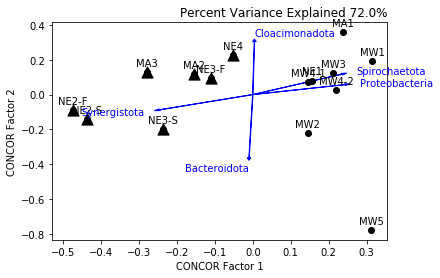

In [6]:
# Run CONCOR!
wa, wb, s, var_explained_a, var_explained_b = cca(np.sqrt(rw), meta_normalized, 5, 3)

# Labels for farms
sids = meta_data.loc['ID_unique'].to_list()

# Plot Lables for OTU/NTUs
NTUs = list(rw.index.values)

NTUs
NTUs = [NTUs[i].split("|", taxa_level-1)[taxa_level-1] for i in range(len(NTUs))]

biplot(np.sqrt(rw), wa, var_explained = var_explained_a, arr_labels=NTUs, obj_labels = sids, meta_data = meta_data, shape = 'AD', n_arrows = 5)
# print(var_explained_a, var_explained_b)
# plt.title(f"Percent Variance Explained {round(var_explained_a*100,1)}%", loc='right')
# plt.savefig("CONCOR_OTU_order.png", dpi=300, bbox_inches='tight', pad_inches=0.5)

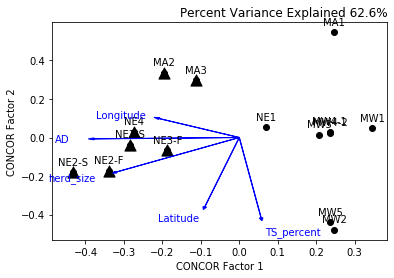

In [7]:
# Set Metadata labes
farmpar = list(meta_normalized.index.values)

biplot(meta_normalized, wb, var_explained = var_explained_b, arr_labels=farmpar, obj_labels=sids, meta_data=meta_data, shape = 'AD', n_arrows = 5)
# plt.savefig("CONCOR_otu_meta_phylum.png", dpi=300, bbox_inches='tight', pad_inches=0.5)

In [8]:
# Get names of the top organisms

top_organism = []
n_arrows = 10

arrow_mag = [wa[i, 0]**2 + wa[i, 1]**2 for i in range(len(wa))]
idx = np.argpartition(arrow_mag, -n_arrows)[-n_arrows:]
arrows = [True if i in idx else False for i in range(len(wa))]

for i in range(len(arrows)):
    if arrows is not None and not arrows[i]:
        continue
    top_organism.append(NTUs[i])

top_organism

['Halobacterota',
 '(Bacteria)',
 'Bacteroidota',
 'Caldatribacteriota',
 'Cloacimonadota',
 'Desulfobacterota',
 'Fusobacteriota',
 'Proteobacteria',
 'Spirochaetota',
 'Synergistota']

# Testing Cells
These cells are scratch work to confirm my scripts were performing as exepcted.

In [ ]:
# Computing Variance explained - Break down

A = np.sqrt(rw)
B = meta_normalized
qa = 5
qb = 3

Ac = A - A.mean(1)[:, None]
Bc = B - B.mean(1)[:, None]

ua, sa, vta = np.linalg.svd(Ac, 0)
ub, sb, vtb = np.linalg.svd(Bc, 0)

# Variance Explained PCA (used equation from first link, above)
var_explained_NTU = np.round(sa**2/np.sum(sa**2), decimals=3)
var_explained_NTU = np.sum(var_explained_NTU[0:qa])/np.sum(var_explained_NTU)
var_explained_NTU

var_explained_meta = np.round(sb**2/np.sum(sb**2), decimals=3)
var_explained_meta = np.sum(var_explained_meta[0:qb])/np.sum(var_explained_meta)
var_explained_meta

## Addressing Missing Metadata
Two of the samples are missing nutrient data. We explored 2 options for dealing with this challenge. First, removing the the two samples without nutrient data and plotting the 13 remaining samples. The other option is just not including nutrient data in the analysis and plotting all 15 samples. We found that the 6 of the families overlapped in the top 10 highest scoring families with a couple exceptions. 

**Top 10 in All Samples**
- Bacteroidaceae: from the phylum Bacteroidetes, which composed of five genera of environmental bacteria
- Lachnospiraceae: anaerobic, spore-forming bacteria in the order Clostridiales that ferment diverse plant polysaccharides to SCFA’s, most abundant taxa in rumen and human GI tract
- Methanosarcinaceae: Methanogenic archaea unique for using unusual amino acid in monomethylamine methyltransferase

**Top 10 in 13 Samples, nutrient data included**
- Fastidiosipila
- Thermacetogeniaceae
- (One Missing?)

Moving forward, we go with the approach of using all samples because the sample size is already limited and because nutrient may have bias towards regions since they were measured in the region they were collected. Also, we don't use sick cow bedding since all but one farm reported sick cow bedding went into the storage. We also use the family-level moving forward. This was selected arbitrarily. Genus and species level data tend to be pretty noisy and we have less confidence in assignment at these levels.

In [ ]:
# Perform CCA with 12 Samples

# Remove Sample_18 and Sample_20 Which are missing Nutrient Data
meta_dropped = meta_data.drop(['Sample_18', 'Sample_20'], axis=1)

# Normalize Metadata (mean 0, standard deviation 1)
meta_normalized = meta_dropped.apply(lambda x:(x-x.mean())/x.std(), axis = 1)

wa, wb, s = cca(np.sqrt(rw.drop(['Sample_18', 'Sample_20'], axis=1)), meta_normalized, 5, 3)

# sid_list = rw.drop(['Sample_18', 'Sample_20'], axis=1).columns.tolist()

sid_list12 = ["MW1","MW2",'MW3',"MW4","MW4","MA1","NE1","NE2","NE3","NE4","MA2","MA3","MW5"]


In [ ]:
s

In [ ]:
NTUs = list(rw.index.values)
NTUs = [NTUs[i].split("_", 4)[4] for i in range(len(NTUs))]

# NTUs[['domain','phylum','class','order', 'Family']] = NTUs.str.split('_', expand=True)

In [ ]:
biplot(np.sqrt(rw.drop(['Sample_18', 'Sample_20'], axis=1)), wa, obj_labels = sid_list12)

# plt.figure(figsize=(5,4))
# plt.savefig("NTUfamily.png", dpi=100, bbox_inches='tight', pad_inches=0.5)

In [ ]:
top_organism = []
n_arrows = 10

arrow_mag = [wa[i, 0]**2 + wa[i, 1]**2 for i in range(len(wa))]
idx = np.argpartition(arrow_mag, -n_arrows)[-n_arrows:]
arrows = [True if i in idx else False for i in range(len(wa))]

for i in range(len(arrows)):
    if arrows is not None and not arrows[i]:
        continue
    top_organism.append(NTUs[i])

top_organism

In [ ]:
print(np.around(wb[:,0]*1000))

In [ ]:
print(np.around(wb[:,0]*1000))

In [ ]:
biplot(np.sqrt(rw), wa, n_arrows=10, arr_labels=NTUs, obj_labels = sid_list14)

plt.savefig("NTUfamily.png", dpi=100, bbox_inches='tight', pad_inches=0.5)

### Summarizing Taxa at different levels: Candidate python code task
This would be a good task to automate with a script so the user can supply the taxonomic level at which to summarize.

#### Psuedocode:

summary_taxa(taxa_column, delimeter, level, filter)

Args: \
taxa_column : list of strings, labes for each level summarized \
level       : level at which user wants to summarize data \
filter      : Boolean, if T, remove eukaryotes

In [ ]:
# Arguments to give python script to make reproducible
taxa_column = ['domain','phylum','class','order','family','genus','species']
delimeter = ";"
df = otu_absolute
level = 5
out_fp = "name_of_summarized_dataframe"

In [ ]:
# Make subset list of levels to summarize
new_level = taxa_column[0:level]

df[taxa_column] = df.OTU.str.split(delimeter, expand=True)

df = df[df['domain']!="Eukaryota"]

new_level.insert(0,'sid')

taxa_sum = df.groupby(new_level)['absolute_copies'].sum().reset_index()
taxa_sum['NTU'] = taxa_sum[taxa_column[0:level]].apply(lambda row: '|'.join(row.values.astype(str)), axis=1)

In [ ]:
# Testing cells for comparing family-level summaries in R and Python

test_fam = pd.read_csv("Final_AMR-NTU_Data/abs_family.tsv", delimiter="\t")

# From first glance, we end up with identical number of families, good!
print(len(test_fam), len(taxa_sum))

# I show in the cell below, disagreement was due to rounding errors
# The differnces were all on the order of 1E-15
test_fam = test_fam.round({'counts': 1})
taxa_sum = taxa_sum.round({'absolute_copies': 1})

r_fam = test_fam['counts'].to_list()
p_fam = taxa_sum['absolute_copies'].to_list()

r_fam.sort() 
p_fam.sort() 
  
# using == to check if  
# lists are equal 
if r_fam == p_fam: 
    print ("The lists are identical") 
else : 
    print ("The lists are not identical") 

In [ ]:
sum_pd = taxa_sum[['sid', 'NTU', 'absolute_copies']].sort_values(by=['absolute_copies','sid']).reset_index()
sum_r = test_fam.sort_values(by=['counts','sid']).reset_index()

sum_pd = sum_pd.round({'absolute_copies': 1})
sum_r = sum_r.round({'counts': 1})

otu_pd = []
abund_pd = []
otu_r = []
abund_r = []
sample_pd = []
sample_r = []
counter = 0

for index, row in sum_pd.iterrows():
    if sum_pd.absolute_copies[index] == sum_r.counts[index]:
        counter += 1
        # print(sum_pd.absolute_copies[index] - sum_r.counts[index])
#         otu_pd.append(sum_pd.NTU[index])
#         abund_pd.append(sum_pd.absolute_copies[index])
#         sample_pd.append(sum_pd.sid[index]) 
#         otu_r.append(sum_r.OTU[index])
#         abund_r.append(sum_r.counts[index])
#         sample_r.append(sum_r.sid[index]) 

counter

# difference = pd.DataFrame({
#     'potu': otu_pd,
#     'rotu': otu_r,
#     'pabund': abund_pd,
#     'rabund': abund_r,
#     'psid': sample_pd,
#     'rsid': sample_r
# })

# difference.to_csv('r_vs_pd.csv', index=None)